In [1]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
!pip install hangul-utils
!pip install jamo

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 33.0 MB/s 
     |████████████████████████████████| 448 kB 16.9 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-10-21 08:54:14--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 18.205.93.1, 18.205.93.2, 18

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
#from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import warnings
warnings.filterwarnings('ignore')

import re
import seaborn as sb

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases
from konlpy.tag import Mecab
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding, Conv1D, MaxPooling1D, BatchNormalization, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score, confusion_matrix
from jamo import h2j, j2hcj

from imblearn.over_sampling import SMOTE
import os

from gensim.models import FastText
from sklearn.neighbors import NearestNeighbors
from hangul_utils import join_jamos

In [5]:
POS = POS = ['CP', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'JO', 'EP', 'EF', 'EC', 
             'NNB', 'ETN', 'ETM', 'VCP', 'VCN', 'SF', 'SY', 'XSN', 'XSV', 'XSA', 'XR', ]

In [6]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))

        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [36]:
def train_load():
  train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/train_data.csv', encoding='cp949')
  train_data['comments'] = train_data['comments'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','')
  
  return train_data

def spliter(text):
    return j2hcj(h2j(text))

def pos_delete(tag, pos):
  for p in pos:
    if (p not in tag) == False:
      return False
    else:
      continue
  
  return True

def tokenize(data):
  mecab = Mecab()
  train_tokenized = []

  for comment in data['comments']:
    ps = mecab.pos(comment)
    tagged = []
    for p in ps:
      if pos_delete(p[1], POS):
        tagged.append(p[0])
    temp_X = [spliter(word) for word in tagged]
    train_tokenized.append(temp_X)
  
  return train_tokenized

def text_tokenize(text):
  mecab = Mecab()
  train_tokenized = []

  ps = mecab.pos(text)
  tagged = []
  for p in ps:
    if pos_delete(p[1], POS):
      tagged.append(p[0])
  temp_X = [spliter(word) for word in tagged]
  train_tokenized.append(temp_X)

  return train_tokenized

def vectorize_data(data, vocab: dict) -> list:
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    
    return vectorized

def build_model(embedding_matrix, maxlen):
  sequence_input = Input(shape=(maxlen,), dtype='int32')
  embedded_sequences = Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],  input_length=maxlen, weights=[embedding_matrix], trainable=False)(sequence_input)
  lstm = Bidirectional(LSTM(32, dropout=0.5, return_sequences = True))(embedded_sequences)
  lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(32, dropout=0.5, return_sequences=True, return_state=True))(lstm)
  state_h = Concatenate()([forward_h, backward_h])
  state_c = Concatenate()([forward_c, backward_c])
  attention = Attention(10)
  context_vector, attention_weights = attention(lstm, state_h)
  dense1 = Dense(20, activation="relu")(context_vector)
  dropout = Dropout(0.05)(dense1)
  output = Dense(1, activation="sigmoid")(dropout)
  model = Model(inputs=sequence_input, outputs=output)

  model.summary()

  return model

def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

def predict_proba(pred):
  proba = []
  for i in range(len(pred)):
    proba.append([float(1-y_train_pred[i]), y_train_pred[i][0]])
  
  return proba

def class_predict(proba):
  return np.argmax(proba, axis=1)

def make_synonyms():
  synonyms_number = 5
  word_number = 20000
  embed_mat = ft_model.wv.vectors
  nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embed_mat)
  neighbours_mat = nn.kneighbors(embed_mat[1:word_number])[1]
  nei_mat = []

  for i in range(len(neighbours_mat)):
    tmp = [join_jamos(ft_model.wv.index2word[s]) for s in neighbours_mat[i]]
    nei_mat.append(tmp)

  synonyms = {nei[0]: nei[1:] for nei in nei_mat}

  return synonyms

def modify_sentence(X_pos, synonyms, p=0.5):
    sentence = [join_jamos(ft_model.wv.index2word[x]) for x in np.trim_zeros(X_pos)]
    for i in range(len(sentence)):
        if np.random.random() > p:
            try:
                syns = synonyms[sentence[i]]
                sentence[i] = np.random.choice(syns)
            except KeyError:
                pass
    return sentence

def text_generator(X_pad, y_data, synonyms):
  X_pos = X_pad[y_data==1]
  n_texts = 15000
  indexes = np.random.randint(0, X_pos.shape[0], n_texts)
  
  X_gen = np.array([modify_sentence(x, synonyms) for x in X_pos[indexes]])
  y_gen = np.ones(n_texts)

  split_X_gen = []
  for i in range(len(X_gen)):
    split_X_gen.append([spliter(gen) for gen in X_gen[i]])

  return split_X_gen, y_gen


In [9]:
ft_model = FastText.load('/content/drive/MyDrive/Colab Notebooks/model/fasttext_310k_spliter.model')

In [10]:
synonyms_number = 5
word_number = 20000
embed_mat = ft_model.wv.vectors
nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embed_mat)
neighbours_mat = nn.kneighbors(embed_mat[1:word_number])[1]
nei_mat = []

for i in range(len(neighbours_mat)):
  tmp = [join_jamos(ft_model.wv.index2word[s]) for s in neighbours_mat[i]]
  nei_mat.append(tmp)

synonyms = {nei[0]: nei[1:] for nei in nei_mat}


In [ ]:
train_data

In [31]:
train_data = train_load()
tokenized_data = tokenize(train_data)
print('Data load complete.')

synonyms = make_synonyms()

X_data = tokenized_data
y_data = train_data['hate'].values

Data load complete.


KeyboardInterrupt: ignored

In [12]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

below_threshold_len(50, X_data)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.68584656084656


In [13]:
max_len = 50
padded_X = pad_sequences(
    sequences=vectorize_data(X_data, vocab=ft_model.wv.vocab),
    maxlen=max_len,
    padding='post'
)

In [14]:
X_pos = padded_X[y_data==1]

In [15]:
split_X_gen, y_gen = text_generator(padded_X, y_data, synonyms)
mix_X = X_data + split_X_gen
mix_y = np.hstack((y_data, y_gen))

In [16]:
max_len = 50
X_pad = pad_sequences(
    sequences=vectorize_data(mix_X, vocab=ft_model.wv.vocab),
    maxlen=max_len,
    padding='post'
)

In [17]:
X_train, X_vt, y_train, y_vt = train_test_split(X_pad, mix_y, test_size=0.1, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_vt, y_vt, test_size=0.3, shuffle=True, random_state=42)
print('Data preprocessing complete.')

Data preprocessing complete.


In [18]:
ft_model.wv.most_similar(spliter('안녕하세요 처음 뵙겠습니다'))

[('ㅎㅘㅅㄸㅣㅇㅎㅏㅅㅔㅇㅛ', 0.9066586494445801),
 ('ㅡㅇㅣㅌㅣㅇㅎㅏㅅㅔㅇㅛ', 0.9010936617851257),
 ('ㅎㅘㅅㅇㅣㅌㅣㅇㅇㅣㅂㄴㅣㄷㅏ', 0.8967157006263733),
 ('ㅎㅘㅅㅌㅣㅇㅇㅣㅂㄴㅣㄷㅏ', 0.8839121460914612),
 ('ㅡㅎㅐㅇㅂㅗㄱㅎㅏㅅㅔㅇㅛ', 0.8800391554832458),
 ('ㅎㅘㅅㅌㅣㅇㅎㅏㅅㅕㅇㅛ', 0.8797280192375183),
 ('ㅎㅘㅅㅌㅣㅇㅎㅏㅅㅔㅇㅛ', 0.8764453530311584),
 ('ㅠㅠㅎㅐㅇㅂㅗㄱㅎㅏㅅㅔㅇㅛ', 0.8719282746315002),
 ('ㅜㅎㅐㅇㅂㅗㄱㅎㅏㅅㅔㅇㅛ', 0.8655703067779541),
 ('ㅎㅘㅅㅌㅣㅇㅎㅏㅅㅔㅇㅛㅇ', 0.8652836084365845)]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 50)       4885200     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 64)       21248       embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 50, 64), (No 24832       bidirectional[0][0]              
______________________________________________________________________________________________

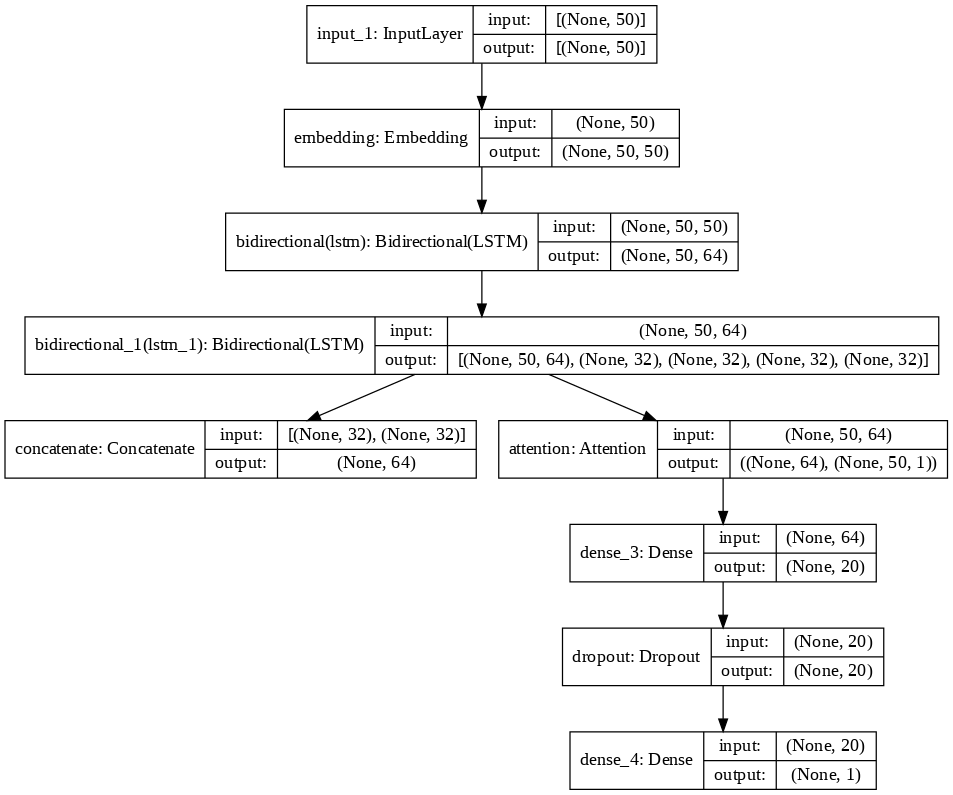

In [20]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]
model = build_model(embedding_matrix=ft_model.wv.vectors, maxlen=max_len)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [21]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=100, epochs=10)

print('Model train complete.')

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_pred_proba = predict_proba(y_train_pred)
test_pred_proba = predict_proba(y_test_pred)

train_preds = class_predict(train_pred_proba)
test_preds = class_predict(test_pred_proba)

print('Data predict complete.')


Epoch 1/10
353/353 [==============================] - 57s 135ms/step - loss: 0.5738 - tp: 11465.0000 - fp: 4725.0000 - tn: 12802.0000 - fn: 6280.0000 - accuracy: 0.6880 - precision: 0.7082 - recall: 0.6461 - auc: 0.7630 - val_loss: 0.5406 - val_tp: 1112.0000 - val_fp: 483.0000 - val_tn: 895.0000 - val_fn: 254.0000 - val_accuracy: 0.7314 - val_precision: 0.6972 - val_recall: 0.8141 - val_auc: 0.8230
Epoch 2/10
353/353 [==============================] - 46s 129ms/step - loss: 0.5238 - tp: 12152.0000 - fp: 3805.0000 - tn: 13722.0000 - fn: 5593.0000 - accuracy: 0.7336 - precision: 0.7615 - recall: 0.6848 - auc: 0.8121 - val_loss: 0.5142 - val_tp: 1105.0000 - val_fp: 410.0000 - val_tn: 968.0000 - val_fn: 261.0000 - val_accuracy: 0.7555 - val_precision: 0.7294 - val_recall: 0.8089 - val_auc: 0.8407
Epoch 3/10
353/353 [==============================] - 45s 129ms/step - loss: 0.4988 - tp: 12257.0000 - fp: 3385.0000 - tn: 14142.0000 - fn: 5488.0000 - accuracy: 0.7484 - precision: 0.7836 - recal

In [117]:
def predictor(text, vocab=ft_model.wv.vocab, maxlen=max_len):
  pattern = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣]')
  text = re.sub(pattern, ' ', text)
  tokenized = text_tokenize(text)
  tokenized_padded = pad_sequences(sequences=vectorize_data(tokenized, vocab=vocab), maxlen=maxlen, padding='post')

  print("Regexed Text:         ", text)
  print("Tokenized Text:       ", tokenized)
  #print("Padded tokenized text:", tokenized_padded)
  
  ratio = round(model.predict(tokenized_padded[0])[0][0] * 100, 2)

  print(f'{ratio}% 확률로 욕설 문장입니다.')
  print('----------------------------------------')
  print('욕설 부분 분석\n')
  badword_list = []
  for idx, token in enumerate(tokenized[0]):
    word = join_jamos(token)
    new_vector = np.zeros(50)
    new_vector[0] = tokenized_padded[0][idx]
    word_ratio = round(model.predict(new_vector)[0][0] * 100, 2)
    print(word + '\t: ' + str(word_ratio) +'% 확률로 욕설 부분')
    if word_ratio > 50:
      badword_list.append(word)
  
  return badword_list

In [125]:
def masker(text, badword):
  masked_text = text
  for bad in badword:
    masked_text = masked_text.replace(bad, '*' * len(bad), 1)
  
  return masked_text

In [137]:
text='저새끼 진짜 개같네'
badword = predictor(text)
masked_text = masker(text, badword)

print('-'*20)
print("Original Text: ", text)
print("Masked Text:   ", masked_text)

Regexed Text:          저새끼 진짜 개같네
Tokenized Text:        [['ㅈㅓ', 'ㅅㅐㄲㅣ', 'ㅈㅣㄴㅉㅏ', 'ㄱㅐ', 'ㄱㅏㅌ']]
47.97% 확률로 욕설 문장입니다.
----------------------------------------
욕설 부분 분석

저	: 47.97% 확률로 욕설 부분
새끼	: 69.87% 확률로 욕설 부분
진짜	: 46.78% 확률로 욕설 부분
개	: 49.15% 확률로 욕설 부분
같	: 45.8% 확률로 욕설 부분
--------------------
Original Text:  저새끼 진짜 개같네
Masked Text:    저** 진짜 개같네


In [138]:
text='아 씨발 진짜 개 좆같네'
badword = predictor(text)
masked_text = masker(text, badword)

print('-'*20)
print("Original Text: ", text)
print("Masked Text:   ", masked_text)

Regexed Text:          아 씨발 진짜 개 좆같네
Tokenized Text:        [['ㅇㅏ', 'ㅆㅣㅂㅏㄹ', 'ㅈㅣㄴㅉㅏ', 'ㄱㅐ', 'ㅈㅗㅈㄱㅏㅌ']]
53.92% 확률로 욕설 문장입니다.
----------------------------------------
욕설 부분 분석

아	: 53.92% 확률로 욕설 부분
씨발	: 68.61% 확률로 욕설 부분
진짜	: 46.78% 확률로 욕설 부분
개	: 49.15% 확률로 욕설 부분
좆같	: 54.16% 확률로 욕설 부분
--------------------
Original Text:  아 씨발 진짜 개 좆같네
Masked Text:    * ** 진짜 개 **네


In [141]:
text='안녕하세요!! 이번에 들어온 사람입니다.'
badword = predictor(text)
masked_text = masker(text, badword)

print('-'*20)
print("Original Text: ", text)
print("Masked Text:   ", masked_text)

Regexed Text:          안녕하세요   이번에 들어온 사람입니다 
Tokenized Text:        [['ㅇㅏㄴㄴㅕㅇ', 'ㅇㅣㅂㅓㄴ', 'ㅅㅏㄹㅏㅁ']]
47.78% 확률로 욕설 문장입니다.
----------------------------------------
욕설 부분 분석

안녕	: 47.78% 확률로 욕설 부분
이번	: 47.95% 확률로 욕설 부분
사람	: 44.1% 확률로 욕설 부분
--------------------
Original Text:  안녕하세요!! 이번에 들어온 사람입니다.
Masked Text:    안녕하세요!! 이번에 들어온 사람입니다.


              precision    recall  f1-score   support

         0.0       0.54      0.38      0.44       607
         1.0       0.50      0.66      0.57       569

    accuracy                           0.51      1176
   macro avg       0.52      0.52      0.50      1176
weighted avg       0.52      0.51      0.50      1176



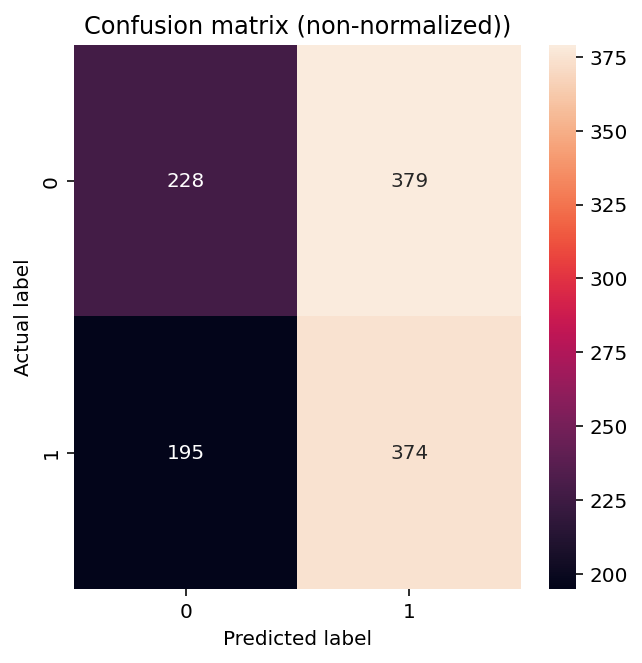

In [130]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
  
report = classification_report(y_test, test_preds)
print(report)
  
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
  
plot_cm(y_test, test_preds)